In [1]:
import pandas as pd

# Load the dataset
file_path = './myCSV.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataframe
data.head()


,Elapsed Time (ms),Alphabet,Pitch,Yaw,Roll,attentive
0,0,,4.168817e-10,0.259005,357.736,1
1,0,,4.168817e-10,0.259005,357.736,1
2,0,,4.168817e-10,0.259005,357.736,1
3,0,,4.168817e-10,0.259005,357.736,1
4,0,,4.168817e-10,0.259005,357.736,1


In [9]:
# Reset the dataset transformation with original attentive column
data['attentive'] = pd.read_csv(file_path)['attentive']

# Re-initialize the variables
attention_value = 0.8  # Starting value

increment = 0.001
decrement = 0.01

# Re-apply the transformation logic with bounds
for i in range(len(data)):
    if data.loc[i, 'attentive'] == 1:
        # Increase the value if attentive, with upper bound
        attention_value = min(attention_value + increment, 0.95)
    else:
        # Decrease the value if not attentive, with lower bound
        attention_value = max(attention_value - decrement, 0.1)
    
    # Update the value in the dataset
    data.loc[i, 'attentive'] = attention_value

# Display the first few rows of the transformed dataframe to verify the changes
data.head()


,Elapsed Time (ms),Alphabet,Pitch,Yaw,Roll,attentive
0,0,,4.168817e-10,0.259005,357.736,0.801
1,0,,4.168817e-10,0.259005,357.736,0.802
2,0,,4.168817e-10,0.259005,357.736,0.803
3,0,,4.168817e-10,0.259005,357.736,0.804
4,0,,4.168817e-10,0.259005,357.736,0.805


In [21]:
# Define the path for the new file
new_file_path = './continuous_myCSV.csv'

# Save the modified dataset to a new CSV file
data.to_csv(new_file_path, index=False)

In [26]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Preprocessing the data for LSTM
# We'll predict 'attentive' based on 'Elapsed Time (ms)', 'Pitch', 'Yaw', and 'Roll'

# Select features and target
features = data[[' Pitch', ' Yaw', ' Roll']]
target = data['attentive']

# Scaling the features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)

# Since LSTM requires the data to be in 3D shape [samples, time steps, features]
# We will reshape the data
time_steps = 1 # Number of time steps to look back which is typically used in time series problems
X = np.reshape(scaled_features, (scaled_features.shape[0], time_steps, scaled_features.shape[1]))
y = target.values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Building the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1)) # Output layer

# Compiling the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model

Epoch 1/100
502/502 [==============================] - 5s 4ms/step - loss: 0.1164 - val_loss: 0.0744
Epoch 2/100
502/502 [==============================] - 2s 3ms/step - loss: 0.0791 - val_loss: 0.0748
Epoch 3/100
502/502 [==============================] - 2s 3ms/step - loss: 0.0779 - val_loss: 0.0740
Epoch 4/100
502/502 [==============================] - 2s 3ms/step - loss: 0.0771 - val_loss: 0.0742
Epoch 5/100
502/502 [==============================] - 2s 3ms/step - loss: 0.0767 - val_loss: 0.0739
Epoch 6/100
502/502 [==============================] - 2s 3ms/step - loss: 0.0766 - val_loss: 0.0740
Epoch 7/100
502/502 [==============================] - 2s 3ms/step - loss: 0.0759 - val_loss: 0.0738
Epoch 8/100
502/502 [==============================] - 2s 3ms/step - loss: 0.0761 - val_loss: 0.0738
Epoch 9/100
502/502 [==============================] - 2s 3ms/step - loss: 0.0754 - val_loss: 0.0744
Epoch 10/100
502/502 [==============================] - 2s 3ms/step - loss: 0.0755 - val_lo

In [28]:
history = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/500
502/502 [==============================] - 2s 3ms/step - loss: 0.0643 - val_loss: 0.0645
Epoch 2/500
502/502 [==============================] - 2s 3ms/step - loss: 0.0642 - val_loss: 0.0649
Epoch 3/500
502/502 [==============================] - 2s 3ms/step - loss: 0.0643 - val_loss: 0.0656
Epoch 4/500
502/502 [==============================] - 2s 3ms/step - loss: 0.0641 - val_loss: 0.0645
Epoch 5/500
502/502 [==============================] - 2s 3ms/step - loss: 0.0643 - val_loss: 0.0657
Epoch 6/500
502/502 [==============================] - 2s 3ms/step - loss: 0.0643 - val_loss: 0.0647
Epoch 7/500
502/502 [==============================] - 2s 3ms/step - loss: 0.0642 - val_loss: 0.0647
Epoch 8/500
502/502 [==============================] - 2s 3ms/step - loss: 0.0641 - val_loss: 0.0643
Epoch 9/500
502/502 [==============================] - 2s 3ms/step - loss: 0.0641 - val_loss: 0.0650
Epoch 10/500
502/502 [==============================] - 2s 3ms/step - loss: 0.0640 - val_lo

126/126 [==============================] - 0s 1ms/step


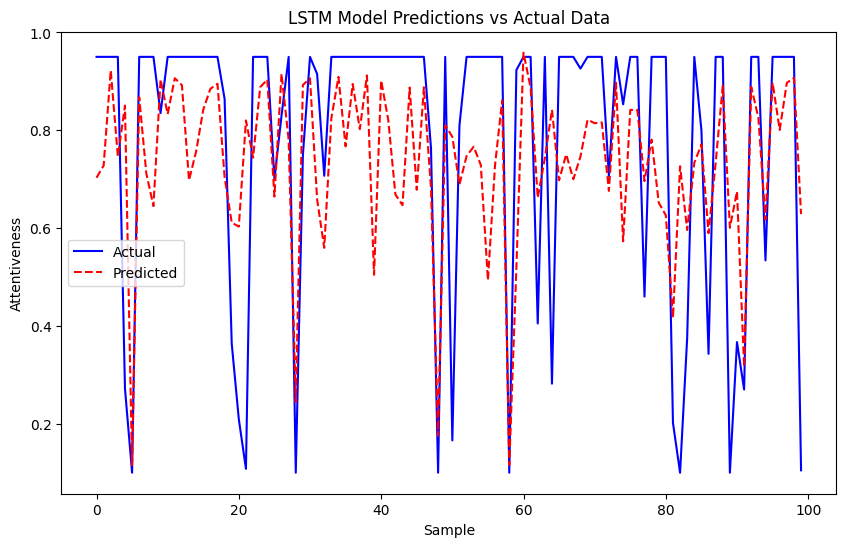

In [29]:
import matplotlib.pyplot as plt
# Make predictions
predictions = model.predict(X_test)

# Plotting the results
plt.figure(figsize=(10,6))
plt.plot(y_test[:100], label='Actual', color='blue')
plt.plot(predictions[:100], label='Predicted', color='red', linestyle='--')
plt.title('LSTM Model Predictions vs Actual Data')
plt.xlabel('Sample')
plt.ylabel('Attentiveness')
plt.legend()
plt.show()

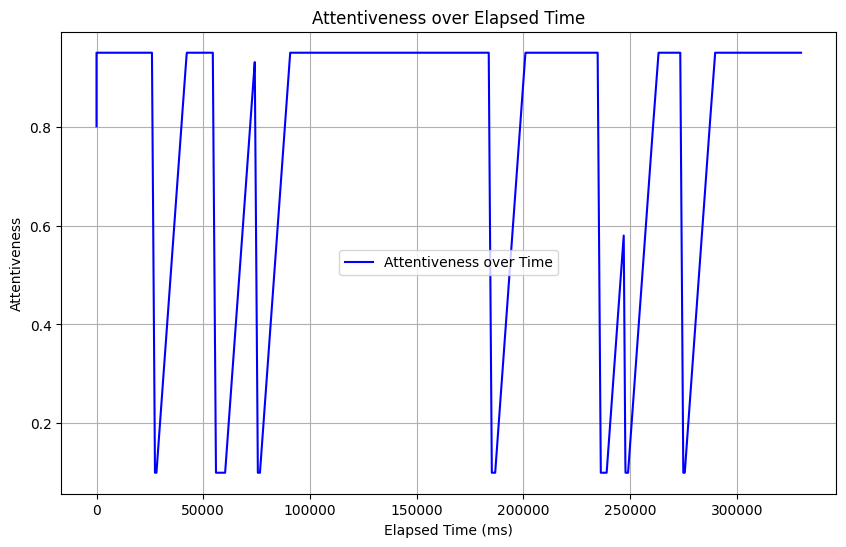

In [11]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(data['Elapsed Time (ms)'], data['attentive'], label='Attentiveness over Time', color='blue')
plt.xlabel('Elapsed Time (ms)')
plt.ylabel('Attentiveness')
plt.title('Attentiveness over Elapsed Time')
plt.legend()
plt.grid(True)
plt.show()


In [5]:
import pandas as pd
import numpy as np
from scipy.stats import mode
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from keras.utils import timeseries_dataset_from_array
import os

In [12]:
def func(timePath, responsePath, timeStamps):
    time_df = pd.read_csv(timePath)
    attention_value = 0.8
    time_df['attentive'] = attention_value
    resp_df = pd.read_csv(responsePath)
    for index, row in resp_df.iterrows():
        if(row[' Correct'] == ' Yes'):
            attention_value += 0.001
            attention_value = min(attention_value, 0.95)
            time_df.loc[row['Elapsed Time (ms)'], 'attentive'] = attention_value
        else:
            attention_value -= 0.1
            attention_value = max(attention_value, 0.1)
            time_df.loc[row['Elapsed Time (ms)'], 'attentive'] = attention_value
    
    # Update time_df and remove old ' Pitch' and ' Roll' columns
    # time_df[' Pitch'] = round(((time_df[' Pitch'] + 180) % 360), 2)
    # time_df[' Roll'] = round(((time_df[' Roll'] + 180) % 360), 2)
    # # time_df[' Yaw'] = round(((time_df[' Yaw'] + 180) % 360), 2)
    
    time_df = time_df.drop(['Elapsed Time (ms)', ' Alphabet'], axis=1)
    dataset = timeseries_dataset_from_array(np.asarray(time_df.drop(['attentive'], axis = 1))[: -timeStamps], np.asarray(time_df['attentive'])[timeStamps:], 10, batch_size=71000)
    for index, batch in enumerate(dataset):
        features, labels = batch
        
       
    return features, labels
    
    
features_arr, labels_arr = func('../data/timeFile_1.csv', '../data/responseFile_1.csv', 10)

In [13]:
# List of response and time file paths
response_files = ['responseFile_1.csv', 'responseFile_3.csv', 'responseFile_4.csv', 'responseFile_5.csv', 'responseFile_6.csv', 'responseFile_7.csv']
time_files = ['timeFile_1.csv', 'timeFile_3.csv', 'timeFile_4.csv', 'timeFile_5.csv', 'timeFile_6.csv', 'timeFile_7.csv']

# Process each file and stack the datasets
stacked_features, stacked_labels = None, None
for time_file, response_file in zip(time_files, response_files):
    dataset = func('../data/' + time_file, '../data/' + response_file, 10)
    if stacked_features is None:
        stacked_features, stacked_labels = dataset
    else:
        stacked_features = np.concatenate([stacked_features, dataset[0]], axis=0)
        stacked_labels = np.concatenate([stacked_labels, dataset[1]], axis=0)

# Print the shapes of the stacked datasets
print("Stacked Features Shape:", stacked_features.shape)
print("Stacked Labels Shape:", stacked_labels.shape)

Stacked Features Shape: (121238, 10, 3)
Stacked Labels Shape: (121238,)


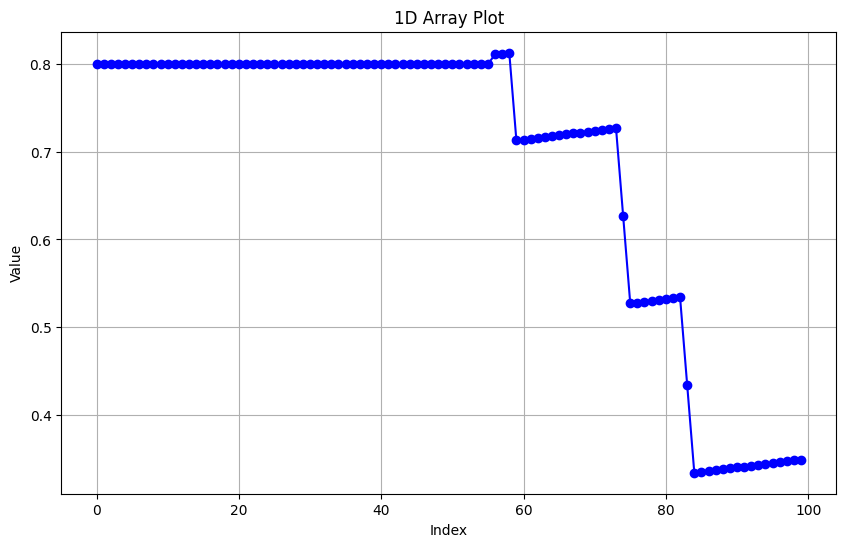

In [14]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(stacked_labels[20000:20100], marker='o', linestyle='-', color='b')  # Plot the data
plt.title('1D Array Plot')  # Title of the plot
plt.xlabel('Index')  # X-axis label
plt.ylabel('Value')  # Y-axis label
plt.grid(True)  # Show grid
plt.show()  # Display the plot


In [53]:
# Assuming stacked_features is already defined and available.
# stacked_features.shape[2] should represent the number of features in each input sequence.

# Define the input layer with the shape (10, number of features)
input_layer = tf.keras.layers.Input(shape=(10, stacked_features.shape[2]))

# Define a stack of LSTM layers in a sequential fashion
lstm_layer1 = tf.keras.layers.LSTM(32, return_sequences=True, activation='tanh', recurrent_dropout=0.2, dropout=0)(input_layer)
lstm_layer2 = tf.keras.layers.LSTM(32, activation='tanh', recurrent_dropout=0.2, dropout=0)(lstm_layer1)

# Define the output layer
hidden_layer = tf.keras.layers.Dense(32, activation='relu')(lstm_layer2)
droput_layer = tf.keras.layers.Dropout(0.35)(hidden_layer)
hidden_layer2 = tf.keras.layers.Dense(32, activation='relu')(droput_layer)
droput_layer2 = tf.keras.layers.Dropout(0.1)(hidden_layer2)
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(droput_layer2)

# Create the sequential model
sequential_model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

sequential_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 10, 3)]           0         
                                                                 
 lstm_6 (LSTM)               (None, 10, 32)            4608      
                                                                 
 lstm_7 (LSTM)               (None, 32)                8320      
                                                                 
 dense_9 (Dense)             (None, 32)                1056      
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_10 (Dense)            (None, 32)                1056      
                                                                 
 dropout_7 (Dropout)         (None, 32)                0   

In [55]:
# Compile the model
sequential_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.binary_crossentropy,
    metrics=['accuracy']
)


train_features = stacked_features[:100000, :, :]
train_labels = stacked_labels[:100000]
test_features = stacked_features[100000:, :, :]
test_labels = stacked_labels[100000:]


nsamples, ntimesteps, nfeatures = train_features.shape
train_features_2d = train_features.reshape((nsamples*ntimesteps, nfeatures))
test_features_2d = test_features.reshape((-1, nfeatures))

# Apply StandardScaler
sc = StandardScaler()
train_features_scaled = sc.fit_transform(train_features_2d)
test_features_scaled = sc.transform(test_features_2d)

# Reshape back to 3D
train_features = train_features_scaled.reshape((nsamples, ntimesteps, nfeatures))
test_features = test_features_scaled.reshape((test_features.shape[0], ntimesteps, nfeatures))

base_history = sequential_model.fit(train_features, train_labels, batch_size=32, epochs=100,
                                    verbose=1, validation_data=(test_features, test_labels), class_weight={0: 1, 1: 10})

Epoch 1/100
3125/3125 [==============================] - 20s 6ms/step - loss: nan - accuracy: 6.1000e-04 - val_loss: nan - val_accuracy: 0.0010
Epoch 2/100
3125/3125 [==============================] - 18s 6ms/step - loss: nan - accuracy: 6.1000e-04 - val_loss: nan - val_accuracy: 0.0010
Epoch 3/100
3125/3125 [==============================] - 19s 6ms/step - loss: nan - accuracy: 6.1000e-04 - val_loss: nan - val_accuracy: 0.0010
Epoch 4/100
3125/3125 [==============================] - 19s 6ms/step - loss: nan - accuracy: 6.1000e-04 - val_loss: nan - val_accuracy: 0.0010
Epoch 5/100
3125/3125 [==============================] - 18s 6ms/step - loss: nan - accuracy: 6.1000e-04 - val_loss: nan - val_accuracy: 0.0010
Epoch 6/100
3125/3125 [==============================] - 17s 5ms/step - loss: nan - accuracy: 6.1000e-04 - val_loss: nan - val_accuracy: 0.0010
Epoch 7/100
3125/3125 [==============================] - 20s 6ms/step - loss: nan - accuracy: 6.1000e-04 - val_loss: nan - val_accuracy:

In [ ]:
# Plot accuracy and loss
fig, ax = plt.subplots(2, 1, figsize=(10,10))
ax[0].plot(base_history.history['accuracy'], label='Train Accuracy')
ax[0].plot(base_history.history['val_accuracy'], label='Validation Accuracy')
ax[0].legend()
ax[0].set_title('Accuracy')

ax[1].plot(base_history.history['loss'], label='Train Loss')
ax[1].plot(base_history.history['val_loss'], label='Validation Loss')
ax[1].legend()
ax[1].set_title('Loss')

plt.tight_layout()
plt.show()

In [ ]:
plt.plot(test_labels, label='Actual')
plt.plot(sequential_model.predict(test_features), label='Predicted')
plt.legend()
plt.show()